# Notebook to generate molecules from Pretrained Models

In [1]:
import sys
sys.path.append('../Optimizer/release')
sys.path.append('../Optimizer')
import pandas as pd
import pickle5 as pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdmolfiles
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles
import os
from joblib import Parallel, delayed
from rdkit.Chem import Crippen
from rdkit.Chem.QED import qed
from Predictors.SolvationPredictor import FreeSolvPredictor
from rdkit.Chem.rdMolDescriptors import CalcTPSA

Using backend: pytorch


In [2]:
use_cuda = torch.cuda.is_available()

In [3]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [4]:
gen_data_path = '../Optimizer/random.smi'

In [5]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [6]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

## Perform docking calculation to fetch binding affinity to receptor

In [17]:
def dock_and_get_score(smile: str, index: int, receptor: str) -> float:
    """
        smile: SMILES string of the molecule
        index: Index of the molecule
        Receptor: PDB ID of receptor
    """
    try:
        path = "~/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24/"
#         path = "python2.5 ~/MGLTools-1.5.6/mgltools_x86_64Linux2_1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24"
        mol = Chem.MolFromSmiles(smile)
        AllChem.EmbedMolecule(mol)
        if not os.path.exists("molecules"):
            os.mkdir("molecules")
        if not os.path.exists("logs"):
            os.mkdir("logs")
        rdmolfiles.MolToPDBFile(mol, "molecules/" + str(index) + ".pdb")
    
        os.system(f"{path}/prepare_ligand4.py -l molecules/{str(index) + '.pdb'} -o molecules/{str(index) + '.pdbqt'}")
        os.system(f"{path}/prepare_receptor4.py -r ../Optimizer/{receptor}.pdb")    
        os.system(f"{path}/prepare_gpf4.py -i ../Optimizer/{receptor}_ref.gpf -l molecules/{str(index) + '.pdbqt'} -r {receptor}.pdbqt")
    
        os.system(f"autogrid4 -p {receptor}.gpf > /dev/null 2>&1")
        os.system(f"~/AutoDock-GPU/bin/autodock_gpu_64wi -ffile {receptor}.maps.fld -lfile molecules/{str(index) + '.pdbqt'} -resnam logs/{str(index)} -nrun 5 -devnum 1")
    
        cmd = f"cat logs/{str(index) + '.dlg'} | grep -i ranking | tr -s '\t' ' ' | cut -d ' ' -f 5 | head -n1"
        stream = os.popen(cmd)
        output = float(stream.read().strip())
        return output
    except Exception as e:
        print(f"Did Not Complete because of {e}")
        return 0

In [8]:
from tqdm.notebook import tqdm
class Predictor(object):
    def __init__(self):
        super(Predictor, self).__init__()
        
    def predict(self, smiles, receptor, use_tqdm=False):
        canonical_indices = []
        invalid_indices = []
        if use_tqdm:
            pbar = tqdm(range(len(smiles)))
        else:
            pbar = range(len(smiles))
        for i in pbar:
            sm = smiles[i]
            if use_tqdm:
                pbar.set_description("Calculating predictions...")
            try:
                sm = Chem.MolToSmiles(Chem.MolFromSmiles(sm))
                if len(sm) == 0:
                    invalid_indices.append(i)
                else:
                    canonical_indices.append(i)
            except:
                invalid_indices.append(i)
        canonical_smiles = [smiles[i] for i in canonical_indices]
        invalid_smiles = [smiles[i] for i in invalid_indices]
        if len(canonical_indices) == 0:
            return canonical_smiles, [], invalid_smiles
        prediction = [dock_and_get_score(smiles[index], index, receptor) for index in tqdm(canonical_indices)]
        return canonical_smiles, prediction, invalid_smiles

## Create KDEPlot of bindaing affinities of generated molecules

In [18]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel='Predicted Docking Score', 
           title='Distribution of predicted Docking for generated molecules')
    plt.show()

In [19]:
def estimate_and_update(generator, predictor, n_to_generate, receptor):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])
    
    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, receptor)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

## Automatically loads the pretrained models given in the repository

In [20]:
def load_pretrained(
    reward, calculator, receptor, 
    LogP_target=None, QED_target=None, 
    hydration_target=None, TPSA_target=None, strategy=None):
    """
        reward: Exponential/Linear (All current models use exponential)
        calculator: docking/gin
        receptor: 4BTK/6LU7
        LogP_target: Optional
        QED_target: Optional
        hydration_target: Optional
        TPSA_target: Optional
        Strategy: None for Single Objective and sum/switch for Multiobjective
    """
    
    file_name = f'../models/{calculator}/model_{reward}_{calculator}_{receptor}'
    if LogP_target:
        file_name += f"_LogP{LogP_target}"
    if QED_target:
        file_name += f"_QED{QED_target}"
    if hydration_target:
        file_name += f"_solvation{hydration_target}"
    if TPSA_target:
        file_name += f"_tpsa{TPSA_target}"
    if strategy:
        file_name += f"_{strategy}"
    hidden_size = 1500
    stack_width = 1500
    stack_depth = 200
    layer_type = 'GRU'
    lr = 0.001
    optimizer_instance = torch.optim.Adadelta
    my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)
    my_generator.load_model(file_name)
    
    if calculator == 'docking':
        pred = Predictor()
    elif calculator == 'gin':
        from Predictors import GINPredictor
        pred = GINPredictor.Predictor('../Optimizer/Predictors/GINPredictor.tar')
    return my_generator, pred

### In the next cell declare the expected target values and keep them None if the model was not optimized for them

The given example fetches the model that is trained only on binding affinity with 4BTK calculated using GIN

In [12]:
kwargs = {
    'reward': 'exponential',
    'calculator': 'gin',
    'receptor': '4BTK',
    'LogP_target': None,
    'QED_target': None,
    'hydration_target': None,
    'TPSA_target': None,
    'strategy': None
}

The given example fetches the model that is trained on binding affinity with 6LU7 calculated using AutoDock-GPU and target LogP of 2.5 by alteranting rewards

In [25]:
kwargs = {
    'reward': 'exponential',
    'calculator': 'docking',
    'receptor': '6LU7',
    'LogP_target': 2.5,
    'QED_target': None,
    'hydration_target': None,
    'TPSA_target': None,
    'strategy': 'switch'
}

In [26]:
model, predictor = load_pretrained(**kwargs)

### Generate SMILES strings and calculate the binding affinities

  0%|          | 0/10 [00:00<?, ?it/s]

../Optimizer/release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
Calculating predictions...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 737.06it/s]


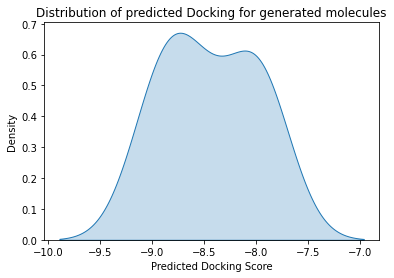

In [14]:
smiles, predictions = estimate_and_update(model, predictor, 10, kwargs['receptor'])

In [27]:
def get_all_props(smiles, predictions):
    mols = [Chem.MolFromSmiles(sm) for sm in smiles]
    LogPs = [Crippen.MolLogP(mol) for mol in mols]
    solv_predictor = FreeSolvPredictor('../Optimizer/Predictors/SolvationPredictor.tar')
    _, hydrations, _ = solv_predictor.predict(smiles, use_tqdm=False)
    tpsas = [CalcTPSA(mol) for mol in mols]
    qeds = []
    for mol in mols:
        try:
            qeds.append(qed(mol))
        except:
            pass
    return pd.DataFrame({
        'Smile': smiles,
        'Binding Affinity': predictions,
        'LogP': LogPs,
        'QED': qeds,
        'TPSA': tpsas,
        '$\Delta G_{Hyd}$': hydrations
    })

In [28]:
df = get_all_props(smiles, predictions)
df

,Smile,Binding Affinity,LogP,QED,TPSA,$\Delta G_{Hyd}$
0,CC(=O)c1ccc(C(Cc2ccccc2)c2ccc(C(=Cc3ccccc3)Cc3...,-8.984436,11.50910,0.088865,51.21,-6.598685
1,CCC(=O)c1ccccc1Oc1cccc(C(NC(=O)c2ccccc2)c2cccc...,-8.059887,7.82200,0.183692,72.47,-8.985065
2,CCc1ccc(C(=O)c2ccc(C(=Cc3ccncc3)c3cccc(-c4ccc(...,-8.681552,9.36190,0.163025,47.03,-8.204513
3,COc1ccc(CCNS(=O)(=O)c2ccc(C(=O)c3ccc(c4ccc(C#N...,-8.557082,9.80148,0.101726,131.79,-10.198419
4,COc1ccc(c2ccc(C(=O)c3ccccc3)cc2)cc1C(=O)c1cccc...,-8.906693,12.32920,0.102935,98.77,-8.992311
5,COc1ccccc1Cn1cc(c2ccccc2-c2ccccc2)nc1C(=NOCc1c...,-8.047053,8.15140,0.085754,91.78,-6.668213
6,O=C(c1ccccc1)N1Cc2cc(c3ccccc3)ccc2CC1c1cncc(Nc...,-7.876609,10.52040,0.092415,88.37,-7.480963
